## Table of Contents:
* [Part 1: Project Intro](#part-1)
* [Part 2: Exploratory data analysis (EDA)](#part-2)
* [Part 3: Data Cleanup](part-3)
* [Part 4: Unsupervised Learning Model](#part-4)
* [Part 5: Supervised Learning Model](#part-5)
* [Part 6: Summary](#part-6)

## Part 1: Project Intro <a class="anchor" id="part-1"></a>

This project will look at passenger data from the Titanic and attempt to predict which passengers survived.  Thie project is on Kaggle and can be found here - [Kaggle Titanic Project](https://www.kaggle.com/competitions/titanic/overview).

You can find this Jupyter notebook hosted on the following public Github repository - [Public Github link for my project](https://github.com/rakin23/unsupervised-week5).

The project contains 3 files:
1. Training data that includes whether the passenger survive
2. Test data that does not include survival info
3. Sample solution data that simply predicts that all females survive and all males did not survive

## Part 2: Exploratory data analysis (EDA) <a class="anchor" id="part-2"></a>
Kaggle provides the following description of the values in the dataset.
**Variable: Definition, Key**
1. survival: Survival, 0 = No, 1 = Yes
2. pclass: Ticket class, 1 = 1st, 2 = 2nd, 3 = 3rd
3. sex: Sex	
4. Age: Age in years	
5. sibsp: # of siblings / spouses aboard the Titanic	
6. parch: # of parents / children aboard the Titanic	
7. ticket: Ticket number	
8. fare: Passenger fare	
9. cabin: Cabin number	
10. embarked: Port of Embarkation, C = Cherbourg, Q = Queenstown, S = Southampton

To start, let's analyze the dataset we've been given to understand the overall data structure, type of data, outliers, etc.  During this EDA we'll be looking for characteristics of the data that may need to be fixed before we can create a learning model based on it.

In [15]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

test_data = pd.read_csv('data/test.csv')
train_data = pd.read_csv('data/train.csv')
sample_solution_data = pd.read_csv('data/gender_submission.csv')

print ("TEST DATA:")
print (test_data.head())
print(test_data.info())

print ("TRAIN DATA:")
print (train_data.head())
print (train_data.info())

print ("SAMPLE SOLUTION:")
print (sample_solution_data.head())
print (sample_solution_data.info())

TEST DATA:
   PassengerId  Pclass                                          Name     Sex  \
0          892       3                              Kelly, Mr. James    male   
1          893       3              Wilkes, Mrs. James (Ellen Needs)  female   
2          894       2                     Myles, Mr. Thomas Francis    male   
3          895       3                              Wirz, Mr. Albert    male   
4          896       3  Hirvonen, Mrs. Alexander (Helga E Lindqvist)  female   

    Age  SibSp  Parch   Ticket     Fare Cabin Embarked  
0  34.5      0      0   330911   7.8292   NaN        Q  
1  47.0      1      0   363272   7.0000   NaN        S  
2  62.0      0      0   240276   9.6875   NaN        Q  
3  27.0      0      0   315154   8.6625   NaN        S  
4  22.0      1      1  3101298  12.2875   NaN        S  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       -

Based on the initial analysis above, I have noticed a few things:
1. The names are sometimes quite long, such as "Hirvonen, Mrs. Alexander (Helga E Lindqvist)".  It's unclear to me what the additional name in parentheses represents, so I'll have to dig into that.
2. The "Cabin" data appears to have many "Nan" values.  
3. The "Sex" data has values of "male" or "female" of type "object".  This may benefit from translating the datatype from "object" to a binary value for improved ability to use this data later.

Those are just a few observations.  Let's look at the data in more depth now.

In [16]:
train_data.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


Now let's look at each individual value in more detail, starting with passenger ID.  I expect each passenger to have a unique ID, so let's confirm that suspicion.  

In [17]:
all_passenger_ids_are_unique = (len(train_data["PassengerId"]) == len(set(train_data["PassengerId"])))
print ("All passenger IDs are unique:", all_passenger_ids_are_unique)  
passenger_id_has_nans = np.isnan(train_data["PassengerId"]).any()
print ("Passenger ID data has nan values:", passenger_id_has_nans)

All passenger IDs are unique: True
Passenger ID data has nan values: False


In [18]:
survived_data_is_all_1_or_0 = all(val == 0 or val == 1 for val in train_data["Survived"])
print ("Survived data is all 1s or 0s:", survived_data_is_all_1_or_0)
survived_data_has_nans = np.isnan(train_data["Survived"]).any()
print ("Survived data has nan values:", survived_data_has_nans)

Survived data is all 1s or 0s: True
Survived data has nan values: False


Pclass data has nan values: False


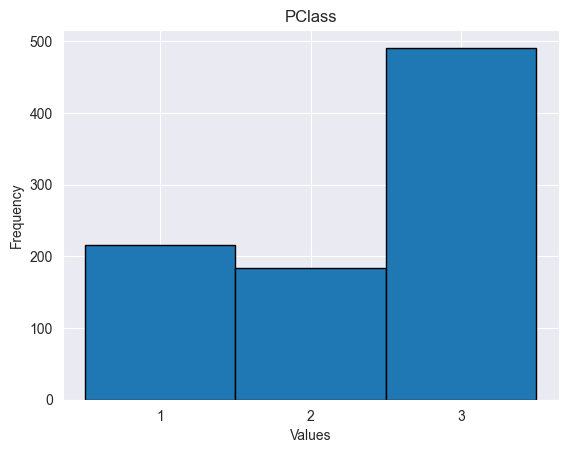

In [19]:
pclass_data_has_nans = np.isnan(train_data["Pclass"]).any()
print ("Pclass data has nan values:", pclass_data_has_nans)

plt.hist(train_data['Pclass'], bins=[1, 2, 3, 4], edgecolor='black', align='left')
plt.title('PClass')
plt.xlabel('Values')
plt.ylabel('Frequency')
plt.xticks([1,2,3])
plt.show()

In [20]:
sex_data_is_all_male_or_female = all(val == 'male' or val == 'female' for val in train_data["Sex"])
print ("Sex data is all either male or female:", sex_data_is_all_male_or_female)

Sex data is all either male or female: True


In [21]:
age_data_has_nans = np.isnan(train_data["Age"]).any()
print ("Age data has nan values:", age_data_has_nans)
num_nan_age_data_entries = np.isnan(train_data["Age"]).sum()
print ("Age data has", num_nan_age_data_entries, "nan entries out of", len(train_data["Age"]), "total, so", round(100 * num_nan_age_data_entries / len(train_data["Age"]),2), "% are nan")

Age data has nan values: True
Age data has 177 nan entries out of 891 total, so 19.87 % are nan


SibSp data has nan values: False
SibSp data are all whole numbers: True


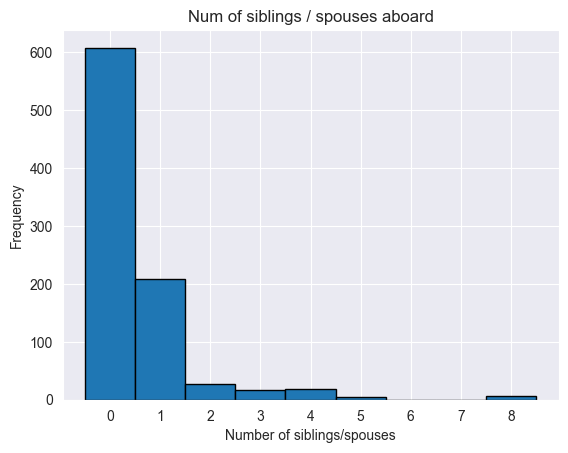

In [22]:
sibsp_data_has_nans = np.isnan(train_data["SibSp"]).any()
print ("SibSp data has nan values:", sibsp_data_has_nans)
sibsp_data_are_all_whole_numbers = all(isinstance(val, int) or (isinstance(val, float) and val.is_integer()) for val in train_data["SibSp"])
print ("SibSp data are all whole numbers:", sibsp_data_are_all_whole_numbers)

plt.hist(train_data["SibSp"], bins=np.arange(10)-0.5, edgecolor='black', align='mid')
plt.title('Num of siblings / spouses aboard')
plt.xlabel('Number of siblings/spouses')
plt.ylabel('Frequency')
plt.xticks(np.arange(9))
plt.show()

Parch data has nan values: False
Parch data are all whole numbers: True


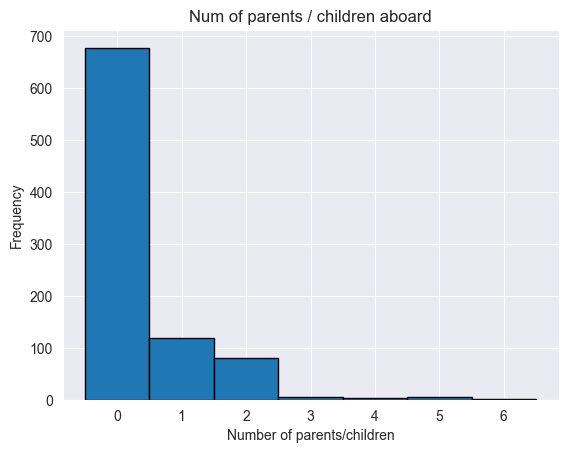

In [23]:
parch_data_has_nans = np.isnan(train_data["Parch"]).any()
print ("Parch data has nan values:", parch_data_has_nans)
parch_data_are_all_whole_numbers = all(isinstance(val, int) or (isinstance(val, float) and val.is_integer()) for val in train_data["Parch"])
print ("Parch data are all whole numbers:", parch_data_are_all_whole_numbers)

plt.hist(train_data["Parch"], bins=np.arange(8)-0.5, edgecolor='black')
plt.title('Num of parents / children aboard')
plt.xlabel('Number of parents/children')
plt.ylabel('Frequency')
plt.xticks(np.arange(7))
plt.show()

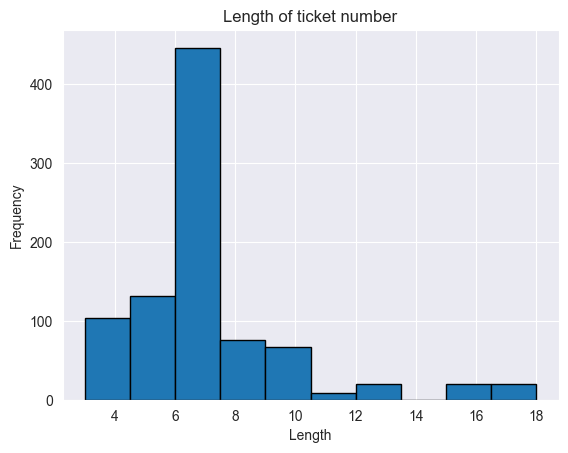

count        891
unique       681
top       347082
freq           7
Name: Ticket, dtype: object

In [24]:
ticket_data_lens = [len(element) for element in train_data["Ticket"]]
plt.hist(ticket_data_lens, bins=10, edgecolor='black')
plt.title('Length of ticket number')
plt.xlabel('Length')
plt.ylabel('Frequency')
plt.show()

train_data["Ticket"].describe()

The ticket numbers are quite odd.  They vary in length quite a bit, as shown in the histogram above.  Also many passengers share the same ticket number (681 unique numbers out of 891 total).  It's unclear what advantage this data may offer to the analysis.  It's possible that passengers with the same ticket number may be staying in the same cabin as one another, but this is unclear.  

Fare data has nan values: False


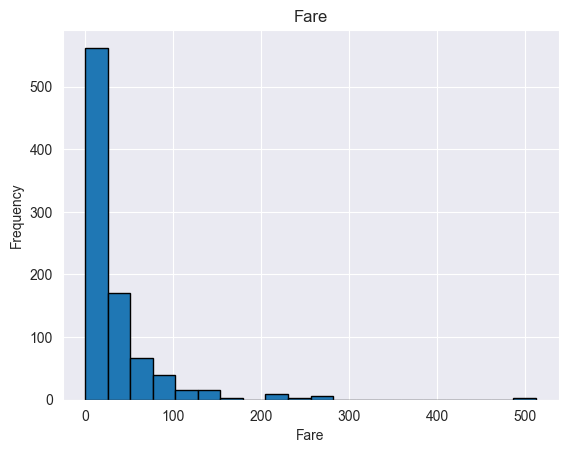

In [25]:
fare_data_has_nans = np.isnan(train_data["Fare"]).any()
print ("Fare data has nan values:", fare_data_has_nans)

plt.hist(train_data["Fare"], bins=20, edgecolor='black')
plt.title('Fare')
plt.xlabel('Fare')
plt.ylabel('Frequency')
plt.show()

"Cabin" data: According to the info printed near the top of this notebook, 204 out of 891 (or 22.90%) entries are non-null, meaning that a large majority of passengers do not have cabin data in this data set.  

"Embarked" data: According to the info printed near the top of this notebook, 889 out of 891 entries are non-null, so we have this data for all passengers except 2.

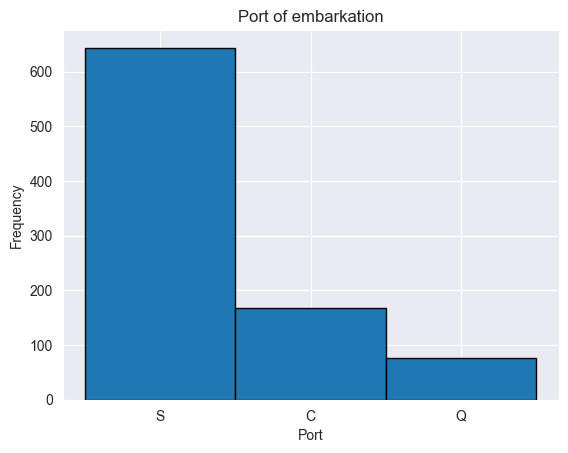

In [26]:
plt.hist([value for value in train_data["Embarked"] if value is not None], bins=np.arange(4)-0.5, edgecolor='black')
plt.title('Port of embarkation')
plt.xlabel('Port')
plt.ylabel('Frequency')
plt.show()

A large majority of passengers embarked from port "S" = Southampton, some embarked from port "C" = Cherbourg, and a small minority embarked from port "Q" = Queenstown.  

## Part 3: Data Cleanup <a class="anchor" id="part-3"></a>

Based on the EDA performed above, we can perform some cleanup.
* Fill in the 19.87% of passengers that have no age data with a meaningful default
* Fill in the 2 passengers that have no embarkation port with a meaningful default
* Combine sibling data with parent/child data to reduce the overall number of features
* Transform categorical variables into numerical values, including gender (male/female) and embarkation (C,Q,S)

In [27]:
def clean_data(data_input):
    data = data_input.copy()
    # Fill in blank age data with random values using the mean and the standard deviation
    age_mean = data["Age"].mean()
    age_std = data["Age"].std()
    is_null = data["Age"].isnull()
    num_null_values = is_null.sum()
    rand_age = np.random.randint(age_mean - age_std, age_mean + age_std, size=num_null_values)
    data.loc[is_null, "Age"] = rand_age
    
    # Also fill in blank embarkation data using the mode
    embarked_mode = data["Embarked"].mode()[0]
    data.fillna({"Embarked": embarked_mode}, inplace=True)
    
    # Combine sibling and parent data into one feature, then delete the sibling and parent columns
    data["Relatives"] = data["SibSp"] + data["Parch"]
    data.drop(['SibSp', 'Parch'], axis=1, inplace=True)
    
    # Update "sex" column to a binary variable in a new column called "sex_male" that is 1 if the passenger is male and 0 if female, then delete the original "sex" column.
    data['Sex_Male'] = (data['Sex'] == 'male').astype(int)
    data.drop(['Sex'], axis=1, inplace=True)
    
    # Create 3 new columns for the embarked values of 'C', 'Q', and 'S', then delete the original 'Embarked' column.
    data['Embarked_C'] = (data['Embarked'] == 'C').astype(int)
    data['Embarked_Q'] = (data['Embarked'] == 'Q').astype(int)
    data['Embarked_S'] = (data['Embarked'] == 'S').astype(int)
    data.drop(['Embarked'], axis=1, inplace=True)
    
    # Set any blank fares to the mean
    fare_mean = data["Fare"].mean()
    is_null = data["Fare"].isnull()
    data.loc[is_null, "Fare"] = fare_mean
    
    # Drop the name, ticket number, and cabin number, which are all text
    data.drop(['Name', 'Ticket', 'Cabin'], axis=1, inplace=True)
    
    return data

train_data_clean = clean_data(train_data)

Now that the data has been cleaned, let's normalize the numerical data using Standard Scaler.

In [28]:
from sklearn.preprocessing import StandardScaler

def scale_data(data_input):
    data = data_input.copy()
    data_numerical_features = list(data.select_dtypes(include=['int64', 'float64']).columns)
    standard_scaler = StandardScaler()
    data[data_numerical_features] = standard_scaler.fit_transform(data[data_numerical_features])
    return data
    
train_data_clean_without_survived = train_data_clean.drop(['Survived'], axis=1)
train_data_scaled = scale_data(train_data_clean_without_survived)
train_data_scaled['Survived'] = train_data['Survived'] # Add back in the unscaled "survived" data

## Part 4: Unsupervised Learning Model <a class="anchor" id="part-4"></a>
Now that we've explored the data, performed data cleanup, and scaled the numerical data the next step is to build a model from the training data to use on the test data.  

** An unsupervised model will likely perform poorly on this data **
In this project I am trying to perform the classification task of predicting whether a passenger survives or not (binary "yes" or "no").  A supervised model will likely be the best fit for this task.  However I will first create an unsupervised learning model to see how it performs before looking at a few supervised learning models.

The unsupervised model I will build will use a KMeans clustering approach to cluster the data together.  An ideal solution would find 2 distinct clusters to indicate the group of passengers that survived and those that didn't.  However, with an unsupervised approach we may discover other clusters in the data that aren't necessarily the ones we're looking for since there's no way to tell the clustering algorithm specifically what we're looking for.  For example, it's possible that it will cluster passengers together based on their economic status or something entirely unexpected rather than clustering together passengers that are likely to survive.  Let's check it out.  

The code below creates an elbow plot of the data to show the inertia vs. the number of clusters.  Inertia is undesirable, so we'd like to see a very low inertia with 2 clusters in the ideal case.  

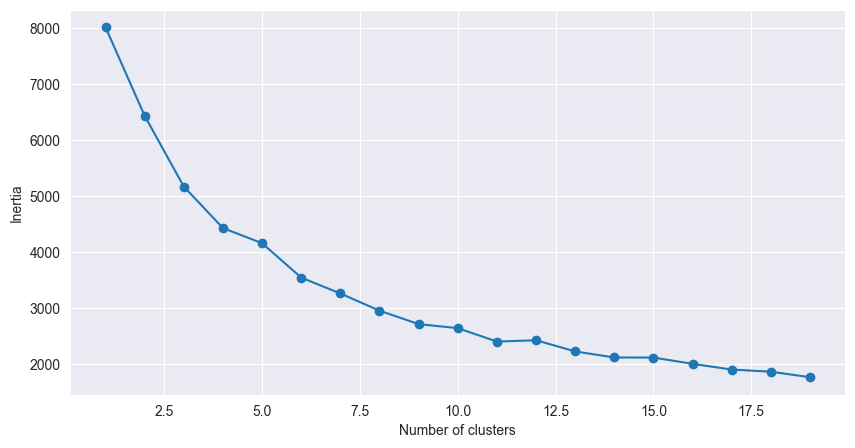

In [29]:
from sklearn.cluster import KMeans

def generate_k_means_plot(data, max_k):
    means = []
    inertias = []
    
    for k in range (1, max_k):
        kmeans = KMeans(n_clusters=k)
        kmeans.fit(data)
        means.append(k)
        inertias.append(kmeans.inertia_)
        
    fix = plt.subplots(figsize=(10, 5))
    plt.plot(means, inertias, 'o-')
    plt.xlabel('Number of clusters')
    plt.ylabel('Inertia')
    plt.grid(True)
    plt.show()
    
generate_k_means_plot(train_data_scaled.drop(['Survived'], axis=1), max_k=20)

The elbow plot unfortunately does not show an elbow at k=2.  While I am sad about this, it's an expected outcome.  As mentioned above, how would the KMeans algorithm know to cluster together passengers that may survive vs. those who don't since we've not provided it with any info on the desired outcome.  It does show an elbow around k=4.  

It's possible that some of those clusters will match closely to the passengers who survived.  Let's go through and create 2^4 = 16 test outputs by assigning each of the 4 clusters to the "survived" or "didn't survive" category, and see how well each of those submissions do.  

Note: The trained KMeans algorithm will not make a "survived" vs. "didn't survive" prediction.  Instead it can look at new data and determine which is the clusters it would belong in.  So, for example, if we randomly assign cluster number 1 to mean "survived" and the trained algorithm predicts that a new unseen passenger would be grouped into cluster number 1, that indicates that the algorithm predicts that passenger will survive.  

In [30]:
from sklearn.metrics import accuracy_score

def int_to_binary_list(integer, num_bits):
    binary_string = bin(integer)[2:].zfill(num_bits)
    binary_list = [int(bit) for bit in binary_string]
    return binary_list

kmeans = KMeans(n_clusters=4, random_state=42)
kmeans.fit(train_data_scaled.drop(['Survived'], axis=1))
accuracy = []
for i in range(16):
    bin_list = int_to_binary_list(i, num_bits=4)
    mapped_labels = []
    for k in range(len(kmeans.labels_)):
        mapped_labels.append(bin_list[kmeans.labels_[k]])
    accuracy.append(accuracy_score(train_data_scaled["Survived"], mapped_labels))
    
print (accuracy)
print ("Max accuracy:", max(accuracy), "with cluster mapping", int_to_binary_list(accuracy.index(max(accuracy)), num_bits=4))

[0.6161616161616161, 0.6621773288439955, 0.5970819304152637, 0.6430976430976431, 0.6363636363636364, 0.6823793490460157, 0.6172839506172839, 0.6632996632996633, 0.3367003367003367, 0.38271604938271603, 0.3176206509539843, 0.36363636363636365, 0.3569023569023569, 0.40291806958473625, 0.3378226711560045, 0.3838383838383838]
Max accuracy: 0.6823793490460157 with cluster mapping [0, 1, 0, 1]


The best permutation achieved a 68.13% accuracy on the train data.  This used mapping [0, 1, 1, 0], which means mapping clusters 1, 3, and 4 to "not survived" and cluster 2 to "survived".  Let's use that to predict survival for the test data, submit it to Kaggle, and see how it performs.  

In [31]:
test_data_cleaned = clean_data(test_data)
test_data_scaled = scale_data(test_data_cleaned)

predictions = kmeans.predict(test_data_scaled)
# Apply the mapping that performed best for the training data
best_bin_list = [0, 1, 1, 0]
mapped_predictions = []
for k in range(len(predictions)):
    mapped_predictions.append(best_bin_list[predictions[k]])

output = pd.DataFrame({'PassengerId': test_data.PassengerId, 'Survived': mapped_predictions})
output.to_csv('submission.csv', index=False)

This achieved a 63.63% accuracy score.  I am optimistic that we can do better with a supervised model, so let's look at a few.  But before we switch over, let's try increasing k from 4 to 8 and repeating the process above.

In [32]:
kmeans = KMeans(n_clusters=8, random_state=42)
kmeans.fit(train_data_scaled.drop(['Survived'], axis=1))
accuracy = []
for i in range(256):
    bin_list = int_to_binary_list(i, num_bits=8)
    mapped_labels = []
    for k in range(len(kmeans.labels_)):
        mapped_labels.append(bin_list[kmeans.labels_[k]])
    accuracy.append(accuracy_score(train_data_scaled["Survived"], mapped_labels))
    
print (accuracy)
print ("Max accuracy:", max(accuracy), "with cluster mapping", int_to_binary_list(accuracy.index(max(accuracy)), num_bits=8))

[0.6161616161616161, 0.6195286195286195, 0.4725028058361392, 0.47586980920314254, 0.5993265993265994, 0.6026936026936027, 0.4556677890011223, 0.4590347923681257, 0.654320987654321, 0.6576879910213244, 0.510662177328844, 0.5140291806958474, 0.6374859708193041, 0.6408529741863075, 0.49382716049382713, 0.49719416386083054, 0.5970819304152637, 0.6004489337822672, 0.45342312008978675, 0.4567901234567901, 0.5802469135802469, 0.5836139169472503, 0.43658810325476993, 0.4399551066217733, 0.6352413019079686, 0.6386083052749719, 0.49158249158249157, 0.494949494949495, 0.6184062850729517, 0.621773288439955, 0.47474747474747475, 0.4781144781144781, 0.5802469135802469, 0.5836139169472503, 0.43658810325476993, 0.4399551066217733, 0.5634118967452301, 0.5667789001122334, 0.41975308641975306, 0.42312008978675647, 0.6184062850729517, 0.621773288439955, 0.47474747474747475, 0.4781144781144781, 0.6015712682379349, 0.6049382716049383, 0.45791245791245794, 0.4612794612794613, 0.5611672278338945, 0.5645342312

In [33]:
test_data_cleaned = clean_data(test_data)
test_data_scaled = scale_data(test_data_cleaned)

predictions = kmeans.predict(test_data_scaled)
# Apply the mapping that performed best for the training data
best_bin_list = [0, 1, 0, 1, 0, 1, 0, 0]
mapped_predictions = []
for k in range(len(predictions)):
    mapped_predictions.append(best_bin_list[predictions[k]])

output = pd.DataFrame({'PassengerId': test_data.PassengerId, 'Survived': mapped_predictions})
output.to_csv('submission.csv', index=False)

This achieved a decent 72.97% accuracy score on the test data.  

In [34]:
all_accuracy_scores = {'KMeans' : 72.97}

## Part 5: Supervised Learning Model <a class="anchor" id="part-5"></a>

In this next section, I'll try a few supervised learning models to see how they performed against the K Means unsupervised algorithm created above.  

In [35]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

train_data_cleaned = clean_data(train_data)
train_data_clean_without_survived = train_data_clean.drop(['Survived'], axis=1)
train_data_scaled = scale_data(train_data_clean_without_survived)

X = train_data_scaled
y = train_data['Survived']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
lr = LogisticRegression(max_iter=1000, random_state=42)
lr.fit(X_train, y_train)
predictions = lr.predict(X_test)
print(classification_report(y_test, predictions))
confusion_matrix(y_test, predictions)

              precision    recall  f1-score   support

           0       0.81      0.87      0.84       157
           1       0.79      0.72      0.75       111

    accuracy                           0.81       268
   macro avg       0.80      0.79      0.80       268
weighted avg       0.81      0.81      0.80       268


array([[136,  21],
       [ 31,  80]])

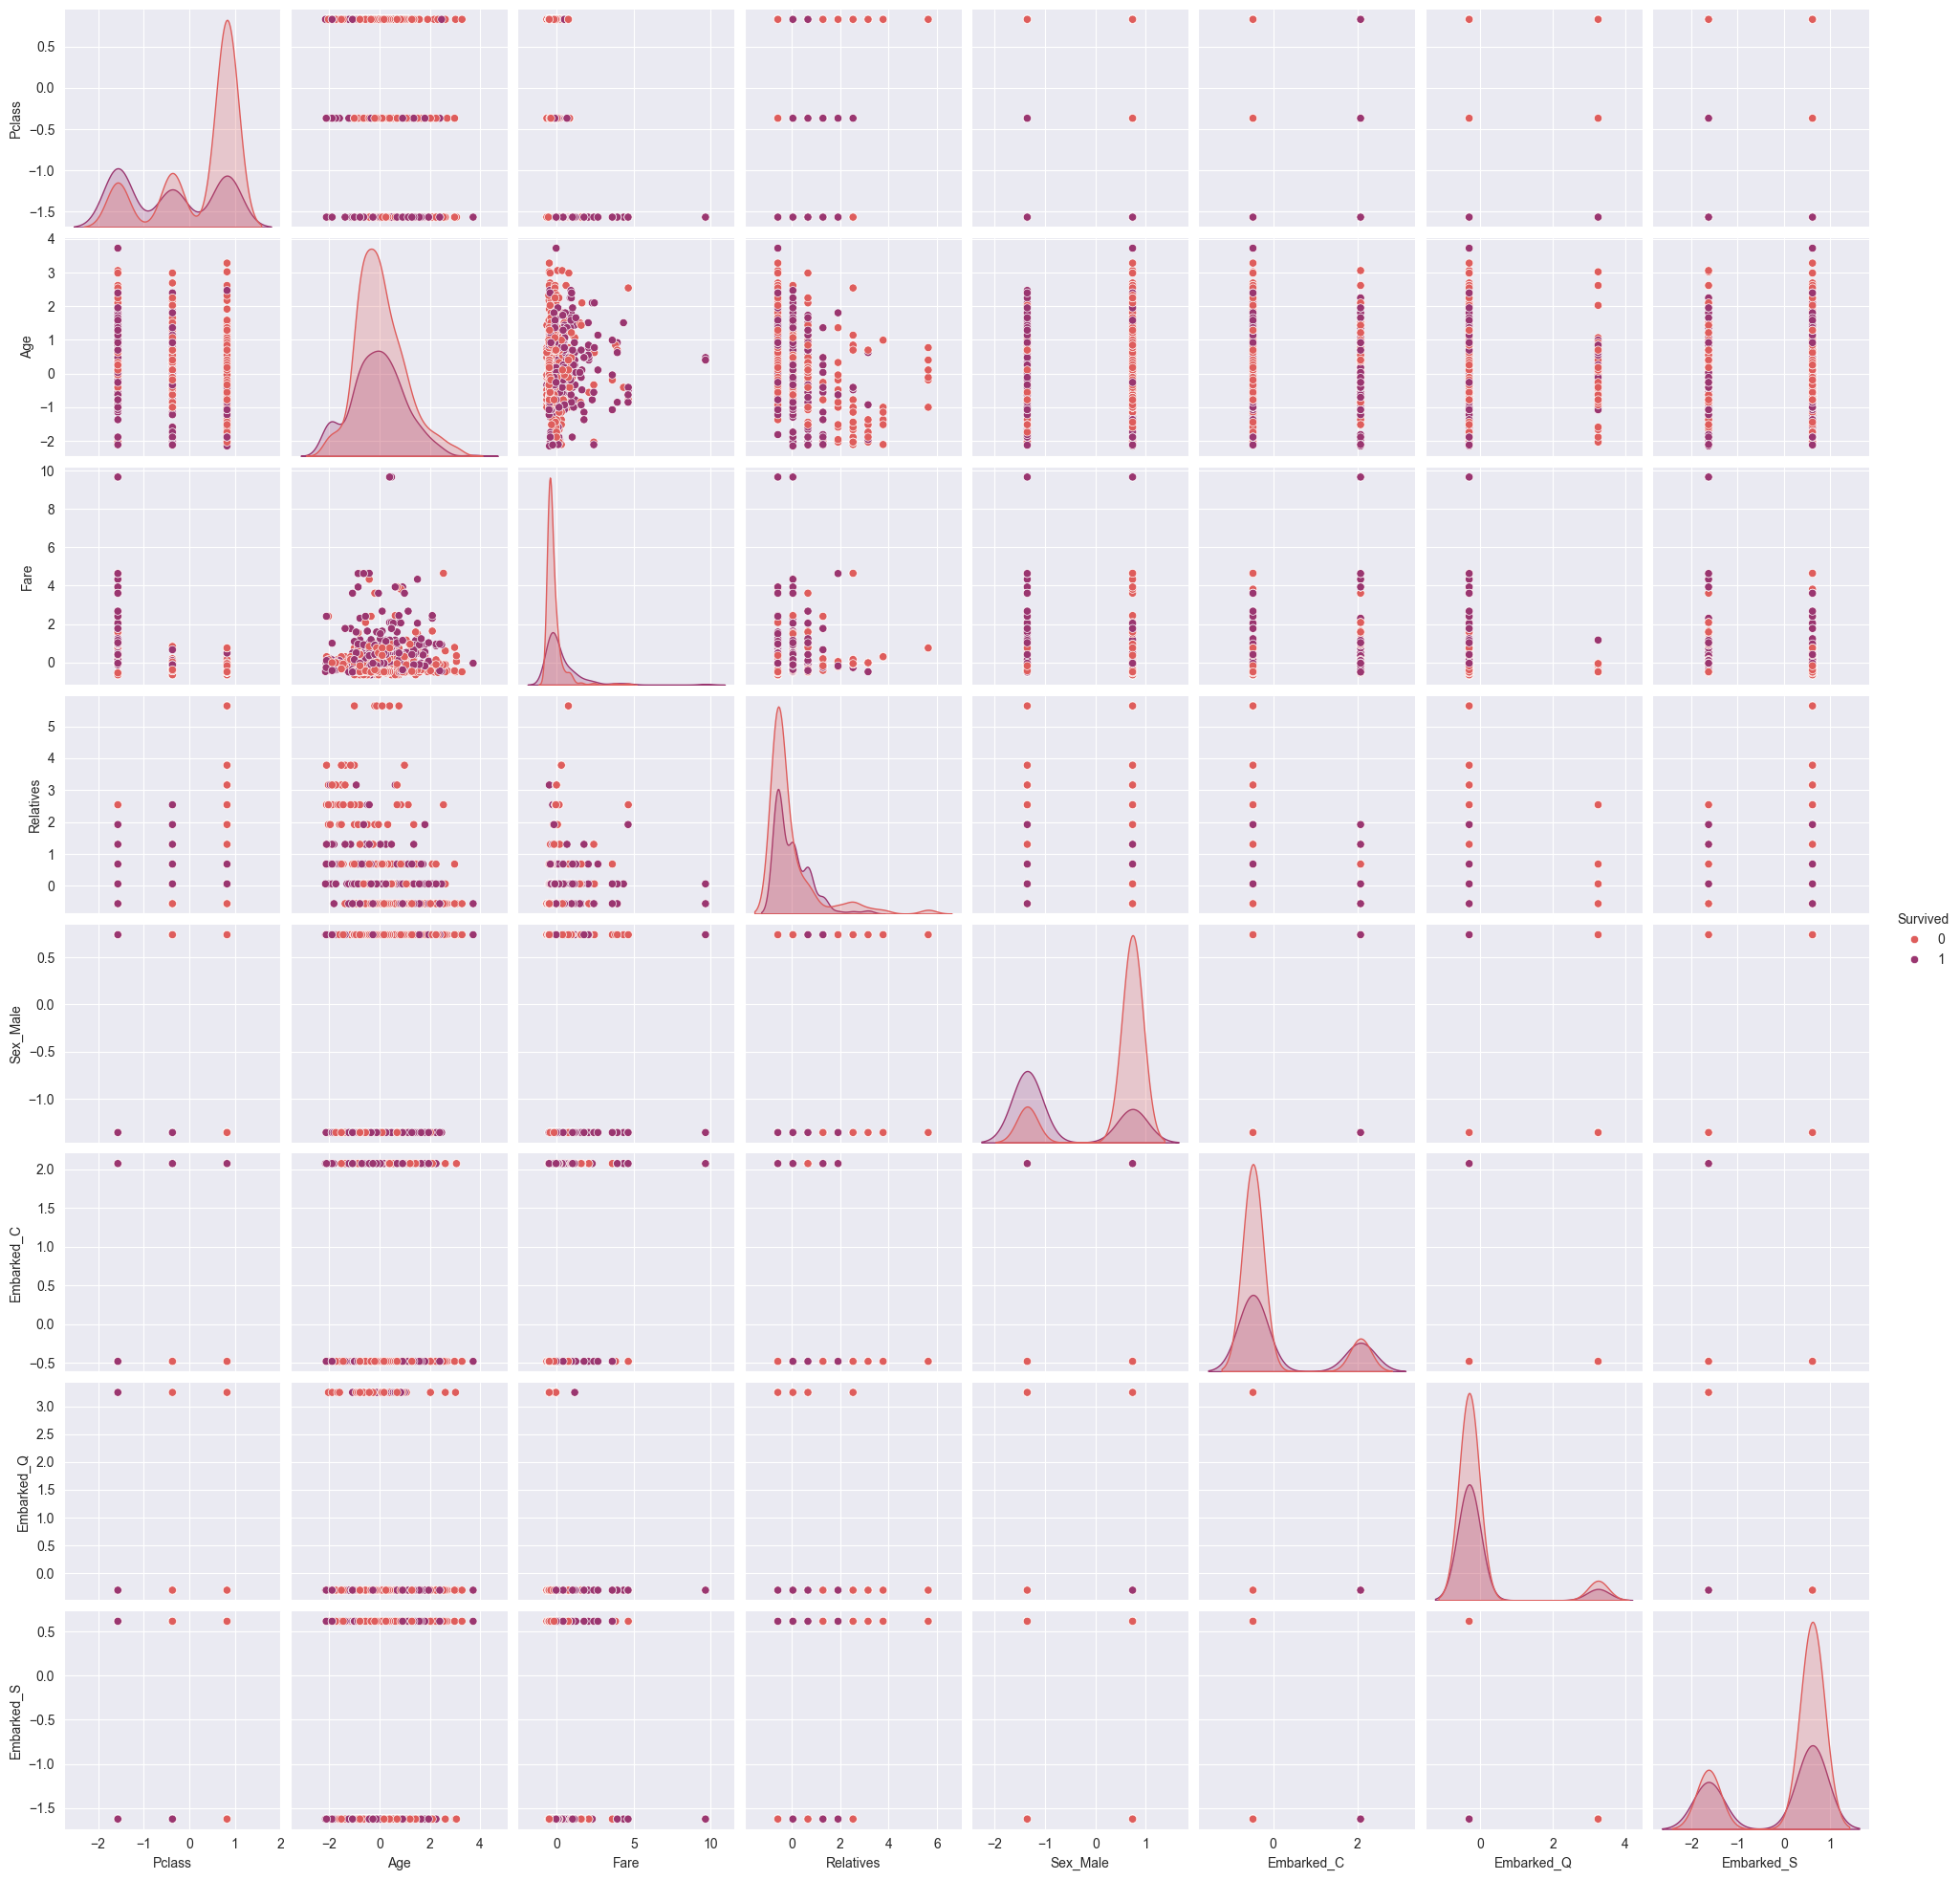

In [36]:
import seaborn as sns

pair_plot_df = train_data_scaled.drop(['PassengerId'], axis=1)
pair_plot_df['Survived'] = train_data['Survived']
sns.pairplot(pair_plot_df, hue='Survived', palette='flare', diag_kind='kde')
plt.show()


test_data_cleaned = clean_data(test_data)
test_data_scaled = scale_data(test_data_cleaned)

predictions = lr.predict(test_data_scaled)
output = pd.DataFrame({'PassengerId': test_data.PassengerId, 'Survived': predictions})
output.to_csv('submission.csv', index=False)

After training a logistic regression model on the training dataset, it then achieved a 76.79% accuracy on the test data set, which I obtained by generating the csv file above and submitting it to Kaggle.  

In [37]:
all_accuracy_scores['LogReg'] = 76.79

Next I'll look at an SVC model and do hyperparameter tuning to find the best hyperparameters

In [38]:
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV

param_grid = {
    'C': [0.1, 1, 10, 100],
    'kernel': ['linear', 'rbf', 'poly'],
    'gamma': ['scale', 'auto']
}

svc = SVC(random_state=42)
grid_search = GridSearchCV(estimator=svc, param_grid=param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train, y_train)
best_params = grid_search.best_params_
print("Best Hyperparameters:", best_params)
best_svm_model = grid_search.best_estimator_
y_pred = best_svm_model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

Best Hyperparameters: {'C': 1, 'gamma': 'auto', 'kernel': 'rbf'}
Accuracy: 0.8097014925373134


In [39]:
test_data_cleaned = clean_data(test_data)
test_data_scaled = scale_data(test_data_cleaned)

predictions = best_svm_model.predict(test_data_scaled)
output = pd.DataFrame({'PassengerId': test_data.PassengerId, 'Survived': predictions})
output.to_csv('submission.csv', index=False)

This achieved an accuracy of 77.75% according to Kaggle.

In [40]:
all_accuracy_scores['SVC'] = 77.75

In [41]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(random_state=42)
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train, y_train)
best_params = grid_search.best_params_
print("Best Hyperparameters:", best_params)
best_rf_model = grid_search.best_estimator_
y_pred = best_rf_model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

Best Hyperparameters: {'max_depth': None, 'min_samples_leaf': 4, 'min_samples_split': 10, 'n_estimators': 200}
Accuracy: 0.8097014925373134


In [42]:
test_data_cleaned = clean_data(test_data)
test_data_scaled = scale_data(test_data_cleaned)

predictions = best_rf_model.predict(test_data_scaled)
output = pd.DataFrame({'PassengerId': test_data.PassengerId, 'Survived': predictions})
output.to_csv('submission.csv', index=False)

76.79% accuracy was achieved with the tuned random forest model.

In [43]:
all_accuracy_scores['Random Forest'] = 76.79
print (all_accuracy_scores)

{'KMeans': 72.97, 'LogReg': 76.79, 'SVC': 77.75, 'Random Forest': 76.79}


## Part 6: Summary <a class="anchor" id="part-6"></a>
I used 4 different learning algorithms (1 unsupervised and 3 supervised).  The best accuracy achieved from each of them is displayed in the graph below.

<BarContainer object of 4 artists>

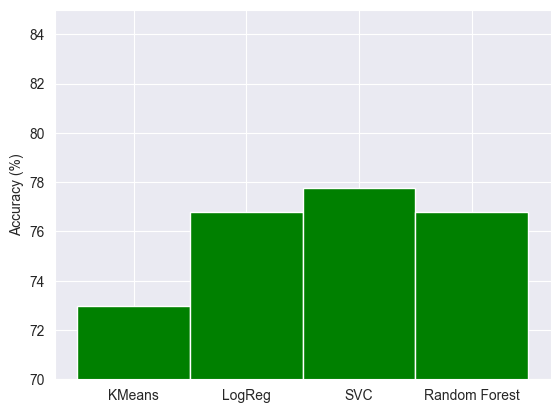

In [44]:
plt.ylim(ymin=70, ymax=85)
plt.ylabel('Accuracy (%)')
plt.bar(all_accuracy_scores.keys(), all_accuracy_scores.values(), 1, color='g')

The 3 supervised algorithms unsurprisingly achieved higher accuracy scores than the unsupervised algorithm for this dataset, and the SVC algorithm performed best with an accuracy of 77.75%.  

### Ideas for future improvement

I dropped the "Name", "Ticket", and "Cabin" features earlier because they were text fields, which makes them challenging to work with.  However, there may be some useful information in those fields that I could use to improve the accuracy.  For example, passengers in the same cabin may be more likely to have the same outcome as one another.  I could encode the "Cabin" field somehow so that I could make use of this data if I were to do another analysis.  